# Day 2 - Multi-armed Bandits

## Incremental Implementation

* The incremental implementation uses constant time and memory to store and update the value estimates
* Let $R_i$ deonte the reward after the $i$th selection $of\ this\ action$, and $Q_n$ the estimate of its value after it has been selected $n-1$ times: $$Q_n\doteq\frac{R_1+R_2+...+R_{n-1}}{n-1}$$
* To compute this incrementally, see this:
$$
\begin{align}
Q_{n+1}&=\frac{1}{n}\left(\sum_{i=1}^nR_i\right) \\
&=\frac{1}{n}\left(R_n+\sum_{i=1}^{n-1}R_i\right) \\
&=\frac{1}{n}\left(R_n+(n-1)\frac{1}{n-1}\sum_{i=1}^{n-1}R_i\right) \\
&=\frac{1}{n}\left(R_n+(n-1)Q_n\right) \\
&=\frac{1}{n}\left(R_n+nQ_n-Q_n\right) \\
&=Q_n+\frac{1}{n}\left(R_n-Q_n\right)
\end{align}
$$
* This has the form of a general update rule that is used often: $$NewEstimate \leftarrow OldEstimate+StepSize\left[Target-OldEstimate\right]$$
* We move the estimate towards the target by a small step
* A small step size is necessary to average out noise
* Step size parameter is usually given by $\alpha$, or more generally by $\alpha_t(a)$

### A simple bandit algorithm

In [1]:
import numpy as np

k = 10
R_true = np.random.normal(size=k)
epsilon = 0.1
Q = np.zeros(k)
N = np.zeros(k)

def bandit(action):
    return np.random.normal(R_true[action])

for _ in range(2000):
    if np.random.random() < epsilon:
        A = np.random.randint(0, k)
    else:
        A = np.argmax(Q)
    R = bandit(A)
    N[A] += 1
    Q[A] += (1/N[A])*(R-Q[A])

for i in range(k):
    print(f"Q({i+1:2d}) = {Q[i]:.3f}\tR({i+1:2d}) = {R_true[i]:.3f}")

def mse(Q, R):
    return np.mean((R-Q)**2)

print(f"MSE: {mse(Q, R_true):5f}")

Q( 1) = 0.212	R( 1) = 0.141
Q( 2) = 1.756	R( 2) = 1.729
Q( 3) = 1.844	R( 3) = 1.847
Q( 4) = 0.055	R( 4) = 0.054
Q( 5) = -0.600	R( 5) = -0.700
Q( 6) = 0.427	R( 6) = 0.849
Q( 7) = 0.556	R( 7) = 0.433
Q( 8) = -0.869	R( 8) = -0.797
Q( 9) = 1.091	R( 9) = 1.136
Q(10) = -0.400	R(10) = -0.493
MSE: 0.022431


## Tracking a Nonstationary Problem

* In RL, we often encounter nonstationary problems
* In this case, the sample-average will not converge, as the underlying true value changes
* A constant step-size parameter $\alpha\in(0,1]$ can track the true value better: $$Q_{n+1}\doteq Q_n+\alpha\left[R_n-Q_n\right]$$
* $Q_{n+1}$ is a weighted average of past rewards:
$$ 
\begin{align}
Q_{n+1}&=Q_n+\alpha\left[R_n-Q_n\right] \\
&=\alpha R_n+(1-\alpha)Q_n \\
&=\alpha R_n+(1-\alpha)\left[\alpha R_{n-1}+(1-\alpha)Q_{n-1}\right] \\
&=\alpha R_n+(1-\alpha)\alpha R_{n-1}+(1-\alpha)^2Q_{n-1} \\
&=\alpha R_n+(1-\alpha)\alpha R_{n-1}+(1-\alpha)^2\alpha R_{n-2}+(1-\alpha)^3Q_{n-2} \\
&=\alpha R_n+(1-\alpha)\alpha R_{n-1}+(1-\alpha)^2\alpha R_{n-2}+(1-\alpha)^3\alpha R_{n-3}+\dots+(1-\alpha)^{n-1}\alpha R_1+(1-\alpha)^nQ_1 \\
&=(1-\alpha)^nQ_1+\sum_{i=1}^n\alpha(1-\alpha)^{n-i}R_i
\end{align}
$$
* This is an $exponential\ recency$-$weighted\ average$
* To ensure convergence, even when varying the step-size, $\alpha_n(a)$, the following has to hold for $\{\alpha_n(a)\}$:
$$
\sum_{n=1}^\infty \alpha_n(a)=\infty\qquad\text{and}\qquad\sum_{n=1}^\infty \alpha_n^2(a)<\infty
$$
* The first condition ensures that the steps don't shrink to zero too fast, and the second ensures overall convergence
* These convergence conditions do not hold for constant step-size, which allows adapting to nonstationary rewards
* The convergence conditions are rarely used in practice

### $Exercise\ \mathcal{2.4}$

#### If the step-size parameters, $\alpha_n$, are not constant, then the estimate $Q_n$ is a weighted average of previously received rewards with a weighting different from that given by (2.6). What is the weighting on each prior reward for the general case, analogous to (2.6), in terms of the sequence of step-size parameters?

$$
\begin{align}
Q_{n+1}&=Q_n+\alpha_n[R_n-Q_n] \\
&=\alpha_nR_n+(1-\alpha_n)Q_n \\
&=\alpha_nR_n+(1-\alpha_n)\alpha_{n-1}R_{n-1}+(1-\alpha_n)(1-\alpha_{n-1})Q_{n-1} \\
&=\alpha_nR_n+(1-\alpha_n)\alpha_{n-1}R_{n-1}+(1-\alpha_n)(1-\alpha_{n-1})\alpha_{n-2}R_{n-2}+\dots+\alpha_1R_1\prod_{i=2}^n(1-\alpha_i)+Q_1\prod_{i=1}^n(1-\alpha_i) \\
&=Q_1\prod_{i=1}^n(1-\alpha_i)+\sum_{i=1}^n\alpha_iR_i\prod_{j=i+1}^{n}(1-\alpha_{j})
\end{align}
$$

### $Exercise\ \mathcal{2.5}\ (programming)$

#### Design and conduct an experiment to demonstrate the difficulties that sample-average methods have for nonstationary problems. Use a modified version of the 10-armed testbed in which all the $q_*(a)$ start out equal and then take independent random walks (say by adding a normally distributed increment with mean 0 and standard deviation 0.01 to all the $q_*(a)$ on each step). Prepare plots like Figure 2.2 for an action-value method using sample averages, incrementally computed, and another action-value method using a constant step-size parameter, $\alpha=0.1$. Use $\varepsilon=0.1$ and longer runs, say of 10,000 steps.

In [170]:
import numpy as np


class KArmedBandit:
    """A multi-armed bandit whose true rewards can drift over time."""

    def __init__(self, k, drift=False):
        """
        Args:
            k (int): Number of arms.
            drift (bool): Whether the true rewards should drift.
        """
        self.k = k
        self.R = np.ones(k) if drift else np.random.normal(size=self.k)
        self.drift=drift

    def step(self, action):
        """
        Draw a reward from a (normal) distribution centered around the
        true value of the selected arm (self.R[action]), and then shift
        all arm values by a small random walk, if self.drift=True.
        
        Args:
            action (int): Arm index to pull.
        
        Returns:
            float: Observed reward.
        """
        R = np.random.normal(self.R[action])
        if self.drift:
            self.R += np.random.normal(scale=0.01, size=self.k)
        return R


class BanditAgent:
    """
    An agent estimating the rewards of a KArmedBandit, using either a
    true sample average, or updating with constant step-size.
    """
    def __init__(self, k, epsilon, step_size=None, initial_values=0):
        """
        Args:
            k (int): Number of actions (bandit's arms).
            epsilon (float): Value for epsilon-greedy action selection.
            step_size (float): (Optional) To use a constant step-size
                instead of the true sample average.
            initial_values (float): Initial value estimates.
        """
        self.Q = np.ones(k, dtype=float) * initial_values
        self.N = np.zeros(k, dtype=int)
        self.epsilon = epsilon
        self.step_size = step_size
        self.rewards = []
        self.optimals = []

    def policy(self):
        """
        Perform epsilon-greedy action selection

        Returns:
            int: Arm index to pull.
        """
        if np.random.random() < self.epsilon:
            return np.random.randint(0, len(self.Q))
        else:
            return np.argmax(self.Q)

    def learn(self, bandit, steps):
        """
        Learn the bandit's action values.

        Args:
            bandit (KArmedBandit): The bandit of which the action values
                are to be estimated.
            steps (int): Number of actions to take to learn.
        """
        for _ in range(steps):
            A = self.policy()
            R = bandit.step(A)
            error = R - self.Q[A]
            if not self.step_size:
                self.N[A] += 1
                self.Q[A] += (1 / self.N[A]) * error
            else:
                self.Q[A] += self.step_size * error
            self.rewards.append(R)
            self.optimals.append(A == np.argmax(bandit.R))

    def mse(self, bandit):
        """
        Returns:
            float: Mean Squared Error of the action value estimates.
        """
        return np.mean((bandit.R - self.Q) ** 2)

In [221]:
from tqdm import tqdm

k = 10
epsilon = 0.1
steps = 10_000
runs = 2_000
step_sizes = [None, 0.1]

rewards = np.zeros((len(step_sizes), runs, steps))
optimals = np.zeros((len(step_sizes), runs, steps))

for run in tqdm(range(runs), desc="Runs"):
    for i, step_size in enumerate(step_sizes):
        bandit = KArmedBandit(k, drift=True)
        agent = BanditAgent(k, epsilon, step_size)
        agent.learn(bandit, steps)
    
        rewards[i,run] = agent.rewards
        optimals[i,run] = agent.optimals

Runs: 100%|███████████████████████████████████████████████████████████| 2000/2000 [02:21<00:00, 14.13it/s]


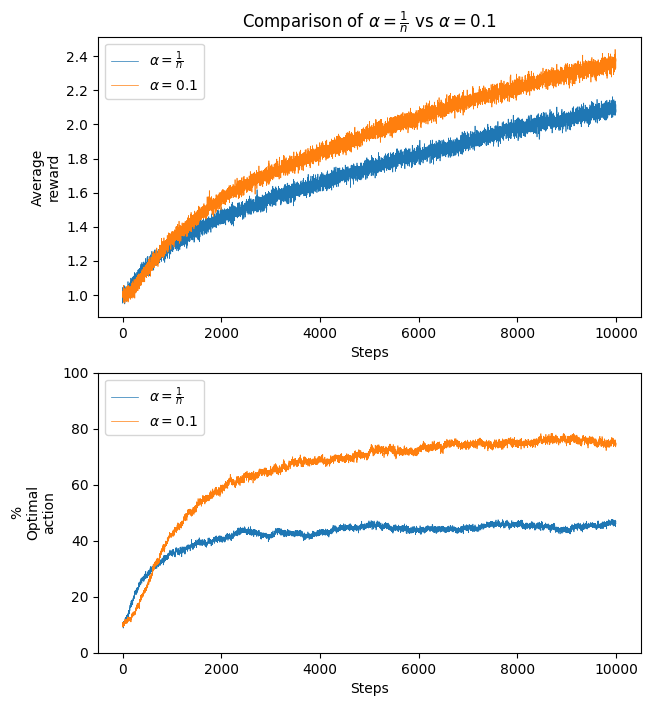

In [227]:
import matplotlib.pyplot as plt

avg_rewards = np.average(rewards, axis=1)
avg_optims = np.average(optimals, axis=1)

fig, (top, bot) = plt.subplots(2, 1, figsize=(7,8))
top.set_title(r"Comparison of $\alpha=\frac{1}{n}$ vs $\alpha=0.1$")
top.plot(avg_rewards[0], label=r"$\alpha=\frac{1}{n}$", linewidth=0.5)
top.plot(avg_rewards[1], label=r"$\alpha=0.1$", linewidth=0.5)
bot.plot(avg_optims[0] * 100, label=r"$\alpha=\frac{1}{n}$", linewidth=0.5)
bot.plot(avg_optims[1] * 100, label=r"$\alpha=0.1$", linewidth=0.5)
top.set_ylabel("Average\nreward")
bot.set_ylabel("%\nOptimal\naction")
bot.set_ylim(0, 100)
for ax in (top, bot):
    ax.set_xlabel("Steps")
    ax.legend()

## Optimistic Initial Values

* All previous methods depend on initial estimates
* Setting these manually is extra effort, but allows imparting some knowledge onto the agent
* By setting initial estimates very high, for example $+5$ in our k-armed bandit example, the agent will select every action often
* This encourages exploration even when the greedy actions are always selected
* This is only really effective in the stationary case, as initial values are only set at the start
* Any methods relying on initial values is unlikely to be helpful with exploration in the nonstationary case

### $Exercise\ \mathcal{2.6}$*:* $Mysterious\ Spikes$

#### The results shown in Figure 2.3 should be quite reliable because they are averages over 2000 individual, randomly chosen 10-armed bandit tasks. Why, then, are there oscillations and spikes in the early part of the curve for the optimistic method? In other words, what might make this method perform particularly better or worse, on average, on particular early steps?

As the initial estimates are wildly optimistic, any action chosen will immediately push that estimate far below those that still have their initial, high value. The first ten steps, then, will be spent going through all ten actions. After this initial exploration, the arm with the highest value estimate is likely the one with the highest true value, which the agent will now choose for several steps, until the estimate is closer to the true value. This seems to happen after just one more step. Then, it will choose the other nine actions again, updating those estimates closer to their real values, which are, on average, again lower than the optimal action's value. This oscillation is dominated by the effect of the high initial estimates early on, but then the inherent stochasticity of the rewards begins to dictate any oscillations.

Runs: 100%|██████████████████████████████████████████████████████████| 2000/2000 [00:02<00:00, 778.23it/s]


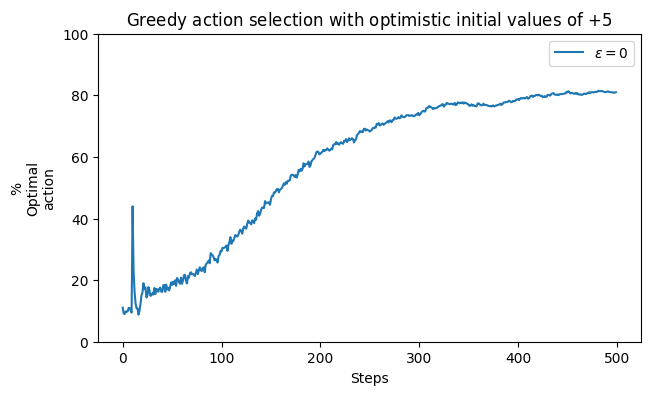

In [233]:
from tqdm import tqdm
import matplotlib.pyplot as plt

k = 10
epsilon = 0.0
initial_values = 5.0
steps = 500
runs = 2_000
step_sizes = [0.1]

rewards = np.zeros((len(step_sizes), runs, steps))
optimals = np.zeros((len(step_sizes), runs, steps))

for run in tqdm(range(runs), desc="Runs"):
    for i, step_size in enumerate(step_sizes):
        bandit = KArmedBandit(k, drift=False)
        agent = BanditAgent(k, epsilon, step_size, initial_values)
        agent.learn(bandit, steps)
    
        rewards[i,run] = agent.rewards
        optimals[i,run] = agent.optimals

avg_optims = np.average(optimals, axis=1)

fig, ax = plt.subplots(figsize=(7,4))
ax.set_title(r"Greedy action selection with optimistic initial values of $+5$")
ax.plot(avg_optims[0] * 100, label=r"$\varepsilon=0$")
ax.set_ylabel("%\nOptimal\naction")
ax.set_ylim(0, 100)
ax.set_xlabel("Steps")
ax.legend()

### $Exercise\ \mathcal{2.7}$*:* $Unbiased\ Constant$-$Step$-$Size\ Trick$

#### In most of this chapter we have used sample averages to estimate action values because sample averages do not produce the initial bias that constant step sizes do (see the analysis leading to (2.6)). However, sample averages are not a completely satisfactory solution because they may perform poorly on nonstationary problems. Is it possible to avoid the bias of constant step sizes while retaining their advantages on nonstationary problems? One way is to use a step size of
$$
\beta_n\doteq\frac{\alpha}{\bar{o}_n},
$$
#### to process the $n$th reward for a particular action, where $\alpha$ > 0 is a conventional constant step size, and $\bar{o}_n$ is a trace of one that starts at $0$:
$$
\bar{o}_n\doteq\bar{o}_{n-1}+\alpha(1-\bar{o}_{n-1}),\quad \text{for }n>0,\quad \text{with }\bar{o}_0\doteq0.
$$
#### Carry out an analysis like that in (2.6) to show that Q n is an exponential recency-weighted average without initial bias.

To borrow from $Exercise\ \mathcal{2.4}$, we start with its result:
$$
\begin{align}
Q_{n+1}&=Q_1\prod_{i=1}^n(1-\beta_i)+\sum_{i=1}^n\beta_iR_i\prod_{j=i+1}^{n}(1-\beta_{j}) \\
&=\sum_{i=1}^n\beta_iR_i\prod_{j=i+1}^{n}(1-\beta_{j}).
\end{align}
$$
This follows immediately from the fact that $1-\beta_1$ is part of the product with the initial estimate $Q_1$, for which we know because
$$
\begin{align}
1-\beta_1&=1-\frac{\alpha}{\bar{o}_1} \\
&=1-\frac{\alpha}{\bar{o}_0+\alpha(1-\bar{o}_{0})} \\
&=1-\frac{\alpha}{0+\alpha(1-0)}=1-\frac{\alpha}{\alpha} \\
&=0,
\end{align}
$$
immediately showing us that the bias term disappears the first time the action is selected.